In [32]:
import os
import csv
import pandas as pd

class DataProcessor:
    def __init__(self, default_strings_to_remove=None):
        # Initialize the default strings to remove from the review text
        self.default_strings_to_remove = default_strings_to_remove or ['+1', '-1']

    def process_file(self, input_file_path, output_file_path=None, remove_sentiment=False, additional_removals=None):
        modified_content = []
        sentiments = []

        # Handle output file path, generate based on input if not specified
        if output_file_path is None:
            output_file_path = os.path.splitext(input_file_path)[0] + '.csv'

        try:
            # Read the input file as raw text instead of using pandas `sep='\n'`
            with open(input_file_path, 'r') as input_file:
                lines = input_file.readlines()

            # Default removal setup: remove sentiment labels if requested
            strings_to_remove = self.default_strings_to_remove if remove_sentiment else []
            if additional_removals:
                strings_to_remove += additional_removals

            # Process each review
            for line in lines:
                # Skip empty reviews or reviews with only whitespace
                if not line.strip():
                    continue

                # Remove the specified strings from the review text
                modified_line = line
                for string_to_remove in strings_to_remove:
                    modified_line = modified_line.replace(string_to_remove, '')

                # Store the modified review content
                if remove_sentiment:  # For train data
                    if '+1' in line or '-1' in line:
                        modified_content.append(modified_line.strip())
                        sentiment = '+1' if '+1' in line else '-1'
                        sentiments.append(sentiment)
                else:  # For test data
                    modified_content.append(modified_line.strip())

            # Write the processed data to a CSV file
            df_output = pd.DataFrame({'Reviews': modified_content})
            if remove_sentiment:
                df_output['Ratings'] = sentiments
            df_output.to_csv(output_file_path, index=False)
            print(f"File '{output_file_path}' successfully written.")

        except FileNotFoundError:
            print(f"Error: File '{input_file_path}' not found.")
        except IOError:
            print(f"Error: Could not write to '{output_file_path}'.")

# Create a processor instance
processor = DataProcessor()

# Process train data
train_input_file_path = 'train.dat'
processor.process_file(train_input_file_path, remove_sentiment=True)

# Verify the output
train_df = pd.read_csv('train.csv')
print("\nTrain CSV Preview:")
print(train_df.head(3))

# Process test data with additional string cleaning
test_input_file_path = 'test.dat'
processor.process_file(test_input_file_path, remove_sentiment=False, additional_removals=['#EOF', '<br />'])

# Verify the output
test_df = pd.read_csv('test.csv')
print("\nTest CSV Preview:")
print(test_df.head(3))

# Display information about the processed data
print(f"\nSize of train_df: {train_df.shape}")
print(f"Column names of train_df: {train_df.columns.tolist()}")

print(f"\nSize of test_df: {test_df.shape}")
print(f"Column names of test_df: {test_df.columns.tolist()}")


File 'train.csv' successfully written.

Train CSV Preview:
                                             Reviews  Ratings
0  One of my all-time favorite so-laughably-lousy...        1
1  I had high hopes for this film, because I thou...       -1
2  When this was released, I thought this was one...       -1
File 'test.csv' successfully written.

Test CSV Preview:
                                             Reviews
0  This is a very low budget film, set in one loc...
1  One minute into THE UNTOLD and it`s already ri...
2  I recently purchased this on DVD as I hadn't h...

Size of train_df: (25000, 2)
Column names of train_df: ['Reviews', 'Ratings']

Size of test_df: (25000, 1)
Column names of test_df: ['Reviews']


In [33]:
import regex as re
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from spellchecker import SpellChecker
import pandas as pd
from tqdm import tqdm

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt') 
nltk.download('punkt_tab') # Added download for punkt resource

# Step 1: Set up stopwords, spell checker, and add negations
stopwords_list = stopwords.words('english')
negations = ['no', 'nor', 'not']
stopwords_list = [word for word in stopwords_list if word not in negations]  # Remove negations from stopwords
stopwords_list.append('eof')  # Add 'eof' to stopwords

spell_checker = SpellChecker()

# Define a dictionary to map bigrams to single-word replacements
bigram_replacements = {
    ('not', 'know'): 'unsure',
    ('not', 'really'): 'doubtful',
    ('not', 'get'): 'miss',
    ('not', 'think'): 'unconsidered',
    ('not', 'even'): 'uneven',
    ('ever', 'seen'): 'unforgettable',
    ('not', 'seen'): 'overlooked',
    ('best', 'ever'): 'unparalleled',
    ('not', 'much'): 'little',
    ('good', 'not'): 'disappointing',
    ('not', 'want'): 'unwanted',
    ('not', 'good'): 'bad',
    ('not', 'see'): 'missed',
    ('really', 'not'): 'doubtful',
    ('not', 'bad'): 'acceptable',
    ('well', 'done'): 'perfect',
    ('pretty', 'good'): 'decent',
    ('even', 'not'): 'unequal',
    ('not', 'quite'): 'almost',
    ('see', 'not'): 'overlooked',
    ('first', 'saw'): 'initial_view',
    ('really', 'good'): 'excellent',
    ('not', 'make'): 'unmade',
    ('great', 'not'): 'average',
    ('much', 'better'): 'improved',
    ('ever', 'made'): 'best_created',
    ('highly', 'recommend'): 'strong_recommendation',
    ('not', 'say'): 'unsaid',
    ('not', 'help'): 'useless',
    ('not', 'even'): 'uneven',
    ('worst', 'ever'): 'abysmal',
    ('ever', 'seen'): 'worst_viewed',
    ('bad', 'bad'): 'worst',
    ('not', 'believe'): 'disbelief',
    ('not', 'see'): 'missed',
    ('not', 'funny'): 'serious',
    ('not', 'waste'): 'wasteful',
    ('not', 'watch'): 'unwatchable'
}

# Define a dictionary to map trigrams to single-word replacements
trigram_replacements = {
    ('not', 'expecting', 'much'): 'unassuming',
    ('not', 'wait', 'next'): 'anticipate',
    ('well', 'put', 'together'): 'organized',
    ('first', 'ever', 'saw'): 'initial_view',
    ('definitely', 'worth', 'watching'): 'must_see',
    ('know', 'going', 'happen'): 'predictable',
    ('best', 'best', 'best'): 'excellent',
    ('not', 'let', 'go'): 'persistent',
    ('not', 'unparalleled', 'made'): 'unmatched_creation',
    ('well', 'written', 'well'): 'well_written',
    ('not', 'well', 'known'): 'obscure',
    ('go', 'ahead', 'make'): 'proceed',
    ('makes', 'feel', 'good'): 'comforting',
    ('not', 'not', 'not'): 'denial',
    ('not', 'go', 'far'): 'limited',
    ('not', 'going', 'get'): 'unattainable',
    ('went', 'bought', 'went'): 'purchased',
    ('bought', 'went', 'bought'): 'purchased_twice',
    ('not', 'last', 'long'): 'temporary',
    ('not', 'work', 'well'): 'ineffective',
    ('not', 'care', 'much'): 'indifferent',
    ('also', 'nice', 'see'): 'pleasant_view',
    ('not', 'wait', 'come'): 'anticipate_arrival',
    ('not', 'stop', 'laughing'): 'hilarious',
    ('not', 'go', 'see'): 'avoid',
    ('going', 'happen', 'next'): 'next_event',
    ('really', 'liked', 'not'): 'disliked',
    ('old', 'black', 'white'): 'vintage_bw',
    ('always', 'rings', 'twice'): 'persistent',
    ('not', 'take', 'long'): 'quick',

    # From Positive Trigrams
    ('not', 'wait', 'see'): 'anticipate',
    ('well', 'worth', 'watching'): 'recommended',
    ('not', 'take', 'seriously'): 'dismiss',
    ('good', 'good', 'good'): 'excellent',
    ('sit', 'back', 'enjoy'): 'relax',
    ('not', 'understand', 'not'): 'confused',
    ('never', 'get', 'tired'): 'enduring',
    ('best', 'seen', 'long'): 'outstanding',
    ('not', 'mean', 'not'): 'uncertain',
    ('last', 'not', 'least'): 'important',
    ('not', 'expect', 'much'): 'unassuming',
    ('no', 'no', 'no'): 'refusal',
    ('not', 'give', 'away'): 'withhold',
    ('well', 'worth', 'seeing'): 'highly_recommended',
    ('never', 'let', 'go'): 'persistent',
    ('definitely', 'worth', 'seeing'): 'must_see',
    ('great', 'great', 'great'): 'fantastic',
    ('good', 'old', 'fashioned'): 'classic',
    ('not', 'go', 'wrong'): 'safe_choice',
    ('look', 'forward', 'seeing'): 'anticipate',
    ('let', 'not', 'forget'): 'remember',
    ('great', 'acting', 'great'): 'stellar_performance',
    ('not', 'wait', 'get'): 'anticipate_retrieval',
    ('not', 'sure', 'not'): 'unsure',
    ('still', 'worth', 'watching'): 'recommendable',
    ('comes', 'highly', 'recommended'): 'strongly_recommended',
    ('saw', 'first', 'came'): 'initial_view',
    ('make', 'feel', 'better'): 'comfort',
    ('pretty', 'much', 'not'): 'mostly_not',
    ('not', 'nearly', 'good'): 'subpar',

    # From Negative Trigrams
    ('no', 'no', 'no'): 'refusal',
    ('not', 'expect', 'much'): 'unassuming',
    ('really', 'wanted', 'like'): 'desired',
    ('not', 'care', 'less'): 'indifferent',
    ('not', 'take', 'seriously'): 'dismiss',
    ('bad', 'acting', 'bad'): 'poor_performance',
    ('last', 'not', 'least'): 'important',
    ('not', 'wait', 'see'): 'anticipate',
    ('not', 'pay', 'see'): 'avoid',
    ('horrible', 'horrible', 'horrible'): 'abysmal',
    ('uneven', 'bad', 'good'): 'inconsistent_quality',
    ('unsaid', 'not', 'warn'): 'unspoken_warning',
    ('not', 'seem', 'know'): 'uncertain',
    ('simply', 'not', 'work'): 'ineffective',
    ('probably', 'abysmal', 'seen'): 'likely_bad',
    ('not', 'ring', 'true'): 'unconvincing',
    ('not', 'understand', 'not'): 'confused',
    ('not', 'mean', 'not'): 'uncertain',
    ('miss', 'wrong', 'love'): 'missed_connection',
    ('not', 'saying', 'much'): 'underwhelming',
    ('no', 'no', 'not'): 'rejection',
    ('bad', 'really', 'bad'): 'terrible',
    ('not', 'stop', 'watching'): 'addictive',
    ('bad', 'acting', 'not'): 'poor_performance',
    ('pretty', 'bad', 'not'): 'mostly_bad',
    ('want', 'watch', 'good'): 'hopeful_view',
    ('find', 'hard', 'believe'): 'disbelief',
    ('let', 'say', 'not'): 'suggest_not',
    ('not', 'give', 'away'): 'withhold',
    ('abysmal', 'seen', 'seen'): 'horrible_experience',

    # Negative trigrams
    ('never', 'get', 'back'): 'irretrievable',
    ('really', 'really', 'bad'): 'terrible',
    ('want', 'see', 'good'): 'hopeful',
    ('looking', 'forward', 'seeing'): 'anticipate',
    ('worst', 'seen', 'long'): 'terrible_long',
    ('uneven', 'get', 'started'): 'disorganized_start',
    ('not', 'enough', 'make'): 'insufficient',
    ('not', 'abysmal', 'seen'): 'mediocre',
    ('not', 'go', 'see'): 'avoid',
    ('not', 'worth', 'watching'): 'forgettable',
    ('let', 'start', 'saying'): 'begin_statement',
    ('uneven', 'come', 'close'): 'inconsistent',
    ('bad', 'acting', 'worst'): 'terrible_performance',
    ('abysmal', 'seen', 'not'): 'horrible',
    ('really', 'looking', 'forward'): 'eager',
    ('not', 'take', 'long'): 'brief',
    ('not', 'care', 'not'): 'apathetic',
    ('make', 'sure', 'not'): 'avoid_confirmation',
    ('possibly', 'abysmal', 'seen'): 'potentially_horrible',
    ('not', 'enough', 'save'): 'unsalvageable',
    ('makes', 'absolutely', 'no'): 'pointless',
    ('bad', 'even', 'worse'): 'deteriorating',
    ('far', 'abysmal', 'seen'): 'extremely_bad',
    ('really', 'bad', 'not'): 'disappointing',
    ('not', 'taken', 'seriously'): 'dismissed',
    ('not', 'worst', 'seen'): 'mediocre',
    ('not', 'find', 'funny'): 'humorless',
    ('seen', 'better', 'acting'): 'superior_performance'
}

# Function to replace trigrams with their single-word alternatives
def replace_trigrams(text, trigram_replacements):
    words = word_tokenize(text)
    
    # If the text has fewer than three words, return the original text
    if len(words) < 3:
        return text

    replaced_words = []
    skip_next = 0  # To skip the second and third words in a trigram after replacement

    for i in range(len(words) - 2):
        if skip_next:
            skip_next -= 1
            continue
        
        trigram = (words[i], words[i + 1], words[i + 2])
        
        if trigram in trigram_replacements:
            # Replace the trigram with the single-word alternative
            replaced_words.append(trigram_replacements[trigram])
            skip_next = 2  # Skip the next two words
        else:
            replaced_words.append(words[i])

    # Add the remaining words if they haven't been processed as part of a trigram
    if skip_next == 0:
        replaced_words.extend(words[-2:])

    return ' '.join(replaced_words)


def replace_bigrams(text, bigram_replacements):
    words = word_tokenize(text)
    
    # If the text has fewer than two words, return the original text
    if len(words) < 2:
        return text

    replaced_words = []
    skip_next = False  # To skip the second word in a bigram after replacement

    for i in range(len(words) - 1):
        if skip_next:
            skip_next = False
            continue
        
        bigram = (words[i], words[i + 1])
        
        if bigram in bigram_replacements:
            # Replace the bigram with the single-word alternative
            replaced_words.append(bigram_replacements[bigram])
            skip_next = True  # Skip the next word
        else:
            replaced_words.append(words[i])

    # Add the last word if it hasn't been processed as part of a bigram
    if not skip_next:
        replaced_words.append(words[-1])

    return ' '.join(replaced_words)


# Function to remove HTML tags
def remove_html_tags(review):
    """Remove HTML tags from the review."""
    return re.sub(r'(<[\w\s]*/?>)', "", review)

# Function to expand contractions
def expand_contractions(review):
    """Expand contractions in the review."""
    return contractions.fix(review)

# Function to lowercase all words
def lowercase_review(review):
    """Convert all characters in the review to lowercase."""
    return review.lower()

# Function to perform spell-check
def spell_check(review, spell_checker):
    """Perform spell-check on the review."""
    return " ".join([spell_checker.correction(word) if spell_checker.correction(word) else word for word in review.split()])

# Function to remove special characters
def remove_special_characters(review):
    """Remove special characters from the review."""
    return re.sub(r'[^a-zA-Z0-9\s]+', "", review)

# Function to remove digits
def remove_digits(review):
    """Remove digits from the review."""
    return re.sub(r'\d+', "", review)

# Function to filter words by POS tags (keep adj, adv, verb, and negations)
def filter_pos_tags(review, stopwords_list):
    """Filter out words and keep only adjectives, adverbs, verbs, and negations."""
    tokenized = word_tokenize(review)
    pos_tags = pos_tag(tokenized)

    allowed_tags = {'JJ', 'JJR', 'JJS',  # Adjectives
                    'RB', 'RBR', 'RBS',  # Adverbs
                    'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}  # Verbs
    
    filtered_words = [
        word for word, tag in pos_tags
        if (tag in allowed_tags or word in negations) and word not in stopwords_list
    ]
    return " ".join(filtered_words)

# Combined preprocessing function to apply all preprocessing steps
def preprocess_review_combined(review, stopwords_list, spell_checker):
    """Combined preprocessing function that applies all preprocessing steps."""
    if isinstance(review, str) and review.strip():  # Ensure the review is not empty or just whitespace
        # 1. Remove HTML tags
        review = remove_html_tags(review)
        
        # 2. Expand contractions
        review = expand_contractions(review)

        # 3. Lowercase all words
        review = lowercase_review(review)

        # 4. (Optional) Spell-check before removing stopwords
        # review = spell_check(review, spell_checker)

        # 5. Remove special characters
        review = remove_special_characters(review)

        # 6. Remove digits
        review = remove_digits(review)

        # 7. Filter words by POS tags to keep adj, adv, verb, and negations
        review = filter_pos_tags(review, stopwords_list)

        # 8. Replace bigrams with their corresponding single words
        review = replace_bigrams(review, bigram_replacements)

        # 9. Replace trigrams with their corresponding single words
        review = replace_trigrams(review, trigram_replacements)

        return review
    else:
        return ""  # Return an empty string for non-string or empty reviews

# Example of how to use the preprocessing functions with your dataset

# Preprocess the reviews in the train data
processed_train_reviews = []
for review in tqdm(train_df['Reviews']):
    processed_train_reviews.append(preprocess_review_combined(review, stopwords_list, spell_checker))

# Add the processed reviews to train_df
train_df['Processed_Reviews'] = processed_train_reviews

# Preprocess the reviews in the test data
processed_test_reviews = []
for review in tqdm(test_df['Reviews']):
    processed_test_reviews.append(preprocess_review_combined(review, stopwords_list, spell_checker))

# Add the processed reviews to test_df
test_df['Processed_Reviews'] = processed_test_reviews

# Creating new DataFrames for the preprocessed data
processed_train_df = pd.DataFrame({
    'Reviews': processed_train_reviews, 
    'Ratings': train_df['Ratings']
})

processed_test_df = pd.DataFrame({
    'Reviews': processed_test_reviews
})

# Saving processed DataFrames
processed_train_df.to_csv('p5_train_df.csv', index=False)
processed_test_df.to_csv('p5_test_df.csv', index=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|██████████| 25000/25000 [02:19<00:00, 178.60it/s]


In [34]:


# Print 10 rows of processed_train_df
print("\nProcessed Train DataFrame:")
print(processed_train_df.head(10))
print("-" * 50)

# Print 10 rows of processed_test_df
print("\nProcessed Test DataFrame:")
print(processed_test_df.head(10))
print("-" * 50)


# Function to print the size and columns of a DataFrame
def print_dataframe_info(df, df_name):
    print(f"\nSize of {df_name}: {df.shape}")  # (rows, columns)
    print(f"Columns in {df_name}: {list(df.columns)}")
    print("-" * 50)

# Print the size and column names of train_df
print_dataframe_info(train_df, "train_df")

# Print the size and column names of test_df
print_dataframe_info(test_df, "test_df")

# Print the size and column names of processed_train_df
print_dataframe_info(processed_train_df, "processed_train_df")


# Print the size and column names of processed_test_df
print_dataframe_info(processed_test_df, "processed_test_df")




Processed Train DataFrame:
                                             Reviews  Ratings
0  alltime favorite istotallylovable nickelndime ...        1
1  high thought clean shaven first absolutely ter...       -1
2  released thought profane best_created however ...       -1
3  watched let go thought improved acting directi...       -1
4  loved much bought including little amazing use...        1
5  come indeed classic speculative destructive ma...        1
6  amazing disappointing wonderful made back earl...        1
7  not alive not guarantee completely accurate ce...        1
8  small tolerable unfortunately instead leaving ...       -1
9  terrible terrible abysmal uneven imagine worse...       -1
--------------------------------------------------

Processed Test DataFrame:
                                             Reviews
0  low set shielded older daughter handsome tough...
1  untold already ripped well seeing sure seeing ...
2  recently purchased not heard carlyleobviously ...



Size of train_df: (25000, 3)
Columns in train_df: ['Reviews', 'Ratings', 'Processed_Reviews']
--------------------------------------------------

Size of test_df: (25000, 2)
Columns in test_df: ['Reviews', 'Processed_Reviews']
--------------------------------------------------

Size of processed_train_df: (25000, 2)
Columns in processed_train_df: ['Reviews', 'Ratings']
--------------------------------------------------

Size of processed_test_df: (25000, 1)
Columns in processed_test_df: ['Reviews']
--------------------------------------------------


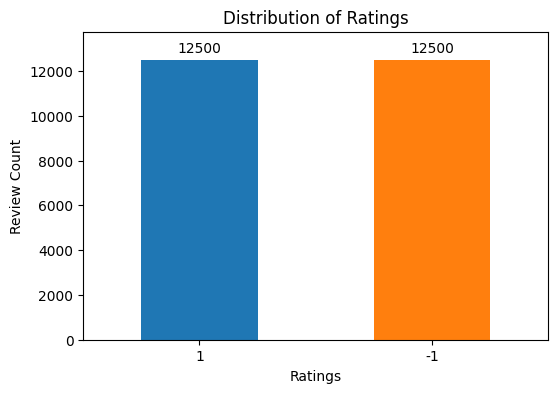

In [36]:
# Written by Ovi, 2024-10-09
# Function to load train.csv and plot distribution of ratings with cool colors, save the figure, print count on top of bars, and add y-axis space

import pandas as pd
import matplotlib.pyplot as plt

# Function to load train.csv and plot distribution
def plot_rating_distribution(train_csv_path, output_image_path='rating_distribution.png'):
    # Load the train.csv file
    df = pd.read_csv(train_csv_path)

    # Count the occurrence of each rating
    rating_counts = df['Ratings'].value_counts()

    # Plot the distribution of ratings with cool colors
    plt.figure(figsize=(6, 4))
    bars = rating_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])  # Using cool colors

    # Set title and labels
    plt.title('Distribution of Ratings')
    plt.xlabel('Ratings')
    plt.ylabel('Review Count')  # Changed to "Review Count"
    plt.xticks(rotation=0)

    # Add count labels on top of the bars
    for bar in bars.patches:
        bars.annotate(format(bar.get_height(), '.0f'), 
                      (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 8),  # 8 points of space above the bar
                      textcoords='offset points')

    # Add some extra space on the y-axis
    plt.ylim(0, rating_counts.max() * 1.1)  # Adding 10% space above the highest bar

    # Save the figure
    plt.savefig(output_image_path, bbox_inches='tight')

    # Show the plot
    plt.show()

# Call the function and pass the path to train.csv and where to save the figure
plot_rating_distribution('train.csv', 'rating_distribution.png')


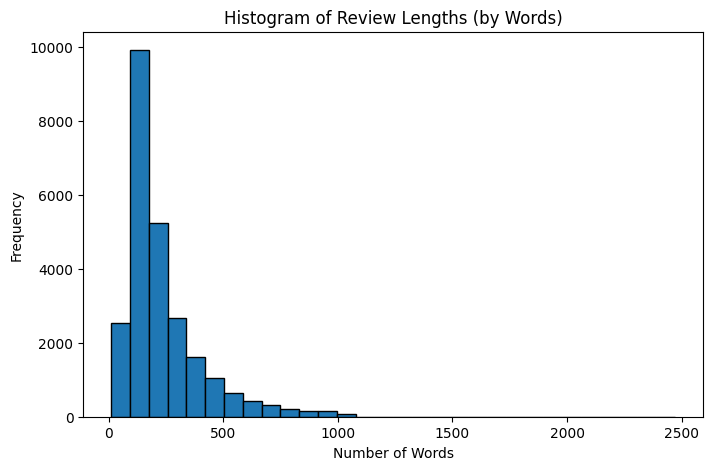

In [37]:
# Written by Ovi, 2024-10-09
# Function to load train.csv, calculate review lengths (by word count), and generate a histogram with cool colors

import pandas as pd
import matplotlib.pyplot as plt

# Function to generate a histogram of review lengths
def plot_review_length_histogram(train_csv_path, output_image_path='review_length_histogram.png'):
    # Load the train.csv file
    df = pd.read_csv(train_csv_path)

    # Calculate the length of each review (in number of words)
    df['Review_Length'] = df['Reviews'].apply(lambda x: len(x.split()))  # Length based on word count

    # Plot the histogram of review lengths with cool colors
    plt.figure(figsize=(8, 5))
    plt.hist(df['Review_Length'], bins=30, color='#1f77b4', edgecolor='black')  # Using a cool color for the histogram
    
    # Set title and labels
    plt.title('Histogram of Review Lengths (by Words)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')

    # Save the figure
    plt.savefig(output_image_path, bbox_inches='tight')

    # Show the plot
    plt.show()

# Call the function and pass the path to train.csv and where to save the figure
plot_review_length_histogram('train.csv', 'review_length_histogram.png')


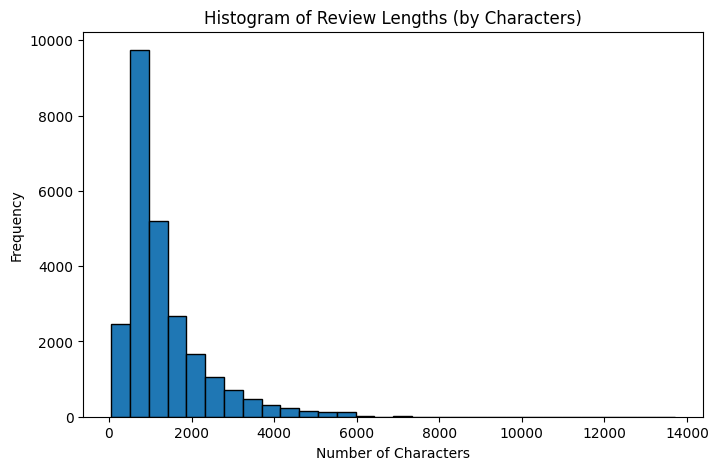

In [38]:
# Written by Ovi, 2024-10-09
# Function to load train.csv, calculate review lengths (in characters), and generate a histogram of review lengths with cool colors

import pandas as pd
import matplotlib.pyplot as plt

# Function to generate a histogram of review lengths (by characters)
def plot_review_length_histogram(train_csv_path, output_image_path='review_length_histogram.png'):
    # Load the train.csv file
    df = pd.read_csv(train_csv_path)

    # Calculate the length of each review (in number of characters)
    df['Review_Length'] = df['Reviews'].apply(len)  # Length based on character count

    # Plot the histogram of review lengths with cool colors
    plt.figure(figsize=(8, 5))
    plt.hist(df['Review_Length'], bins=30, color='#1f77b4', edgecolor='black')  # Using a cool color for the histogram
    
    # Set title and labels
    plt.title('Histogram of Review Lengths (by Characters)')
    plt.xlabel('Number of Characters')
    plt.ylabel('Frequency')

    # Save the figure
    plt.savefig(output_image_path, bbox_inches='tight')

    # Show the plot
    plt.show()

# Call the function and pass the path to train.csv and where to save the figure
plot_review_length_histogram('train.csv', 'review_length_histogram_by_characters.png')



Top 10 Positive Words: [('not', 20120), ('good', 6069), ('great', 5968), ('also', 5414), ('see', 5151), ('well', 4880), ('no', 4345), ('really', 4277), ('first', 4256), ('even', 4086), ('much', 3909), ('best', 3720), ('many', 3710), ('little', 3695), ('get', 3556), ('made', 3470), ('still', 3253), ('never', 3151), ('think', 3084), ('make', 2860)]

Top 10 Negative Words: [('not', 23979), ('no', 7566), ('bad', 6331), ('good', 5571), ('even', 5353), ('really', 4573), ('see', 4542), ('made', 4193), ('get', 4079), ('first', 4044), ('much', 3903), ('make', 3821), ('little', 3579), ('also', 3471), ('well', 3300), ('never', 3168), ('think', 2972), ('many', 2870), ('better', 2757), ('say', 2666)]


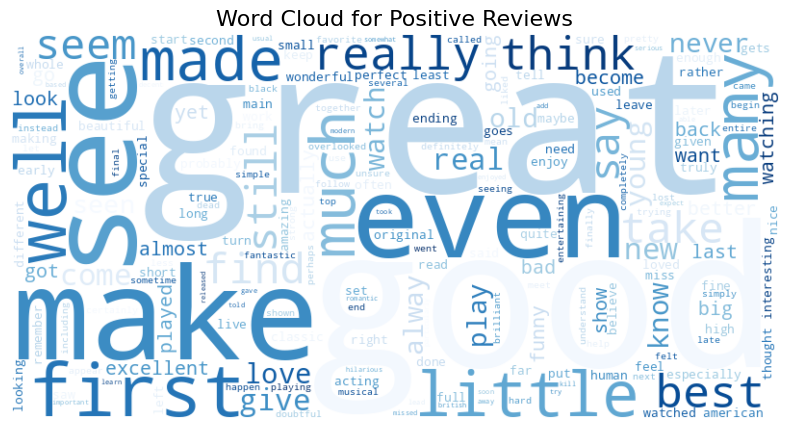

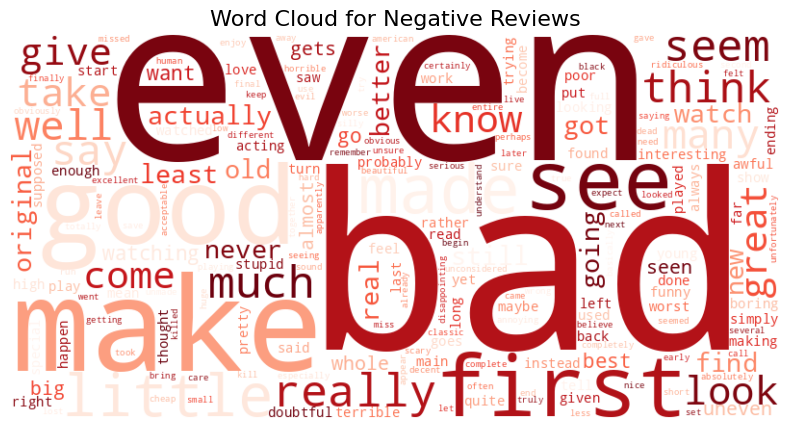

In [39]:
# Written by Ovi, 2024-10-09
# Function to generate word clouds for positive and negative reviews using the 'Reviews' column in processed_train_df
# Also prints the most common words

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Function to generate word clouds for positive and negative reviews
def generate_wordclouds(processed_train_df, pos_output_image='positive_wordcloud.png', neg_output_image='negative_wordcloud.png'):
    # Ensure there are no missing values in 'Reviews'
    df = processed_train_df.dropna(subset=['Reviews'])  # Use 'Reviews' column

    # Separate positive and negative reviews based on the Ratings column
    positive_reviews = df[df['Ratings'] == 1]['Reviews'].str.cat(sep=' ')  # Use 'Reviews' column
    negative_reviews = df[df['Ratings'] == -1]['Reviews'].str.cat(sep=' ')  # Use 'Reviews' column

    # Tokenize and count word frequencies for positive and negative reviews
    positive_word_counts = Counter(positive_reviews.split())
    negative_word_counts = Counter(negative_reviews.split())

    # Print the top 10 most common words in positive and negative reviews
    top_positive_words = positive_word_counts.most_common(20)
    top_negative_words = negative_word_counts.most_common(20)
    
    print("\nTop 10 Positive Words:", top_positive_words)
    print("\nTop 10 Negative Words:", top_negative_words)

    # Check if there are any positive reviews
    if positive_reviews.strip():
        # Generate word cloud for positive reviews
        wordcloud_pos = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(positive_reviews)

        # Plot and save the word cloud for positive reviews
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud_pos, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud for Positive Reviews', fontsize=16)
        plt.savefig(pos_output_image, bbox_inches='tight')
        plt.show()
    else:
        print("No positive reviews available for word cloud generation.")

    # Check if there are any negative reviews
    if negative_reviews.strip():
        # Generate word cloud for negative reviews
        wordcloud_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_reviews)

        # Plot and save the word cloud for negative reviews
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud_neg, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud for Negative Reviews', fontsize=16)
        plt.savefig(neg_output_image, bbox_inches='tight')
        plt.show()
    else:
        print("No negative reviews available for word cloud generation.")

# Call the function and pass the processed_train_df and where to save the word clouds
generate_wordclouds(processed_train_df, 'positive_wordcloud.png', 'negative_wordcloud.png')





In [40]:
from collections import Counter
from nltk import word_tokenize
from nltk.util import ngrams

# Function to generate bigram frequency for positive and negative reviews
def generate_bigram_frequencies(processed_train_df, top_n=30):
    # Ensure there are no missing values in 'Reviews'
    df = processed_train_df.dropna(subset=['Reviews'])  # Use 'Reviews' column

    # Separate positive and negative reviews based on the Ratings column
    positive_reviews = df[df['Ratings'] == 1]['Reviews'].str.cat(sep=' ')  # Use 'Reviews' column
    negative_reviews = df[df['Ratings'] == -1]['Reviews'].str.cat(sep=' ')  # Use 'Reviews' column

    # Function to get bigrams from a review
    def get_bigrams(text):
        tokens = word_tokenize(text.lower())  # Tokenize and lowercase the text
        bigrams = list(ngrams(tokens, 2))     # Generate bigrams
        return bigrams

    # Generate bigrams for positive and negative reviews
    positive_bigrams = get_bigrams(positive_reviews)
    negative_bigrams = get_bigrams(negative_reviews)

    # Count the frequency of bigrams
    positive_bigram_counts = Counter(positive_bigrams)
    negative_bigram_counts = Counter(negative_bigrams)

    # Print the top n most common bigrams in positive and negative reviews
    top_positive_bigrams = positive_bigram_counts.most_common(top_n)
    top_negative_bigrams = negative_bigram_counts.most_common(top_n)

    print("\nTop 20 Positive Bigrams:", top_positive_bigrams)
    print("\nTop 20 Negative Bigrams:", top_negative_bigrams)

# Example usage
generate_bigram_frequencies(processed_train_df)



Top 20 Positive Bigrams: [(('not', 'not'), 227), (('never', 'seen'), 215), (('black', 'white'), 206), (('not', 'seem'), 197), (('pretty', 'much'), 196), (('not', 'sure'), 196), (('not', 'great'), 176), (('not', 'understand'), 171), (('highly', 'recommended'), 163), (('no', 'not'), 160), (('not', 'go'), 158), (('want', 'see'), 156), (('not', 'always'), 156), (('go', 'see'), 155), (('well', 'not'), 150), (('not', 'going'), 148), (('first', 'not'), 145), (('not', 'best'), 142), (('not', 'like'), 141), (('never', 'really'), 140), (('not', 'find'), 137), (('not', 'miss'), 135), (('not', 'expect'), 132), (('not', 'take'), 131), (('good', 'good'), 129), (('not', 'exactly'), 128), (('probably', 'not'), 126), (('say', 'not'), 125), (('many', 'not'), 125), (('also', 'good'), 124)]

Top 20 Negative Bigrams: [(('pretty', 'much'), 358), (('not', 'not'), 328), (('abysmal', 'seen'), 312), (('not', 'seem'), 281), (('not', 'enough'), 267), (('bad', 'not'), 267), (('want', 'see'), 264), (('no', 'not'),

In [42]:
from collections import Counter
from nltk import word_tokenize
from nltk.util import ngrams

# Function to generate bigram frequency for positive and negative reviews
def generate_bigram_frequencies(processed_train_df, top_n=30):
    # Ensure there are no missing values in 'Reviews'
    df = processed_train_df.dropna(subset=['Reviews'])  # Use 'Reviews' column

    # Separate positive and negative reviews based on the Ratings column
    positive_reviews = df[df['Ratings'] == 1]['Reviews'].str.cat(sep=' ')  # Use 'Reviews' column
    negative_reviews = df[df['Ratings'] == -1]['Reviews'].str.cat(sep=' ')  # Use 'Reviews' column

    # Function to get bigrams from a review
    def get_bigrams(text):
        tokens = word_tokenize(text.lower())  # Tokenize and lowercase the text
        bigrams = list(ngrams(tokens, 3))     # Generate bigrams
        return bigrams

    # Generate bigrams for positive and negative reviews
    positive_bigrams = get_bigrams(positive_reviews)
    negative_bigrams = get_bigrams(negative_reviews)

    # Count the frequency of bigrams
    positive_bigram_counts = Counter(positive_bigrams)
    negative_bigram_counts = Counter(negative_bigrams)

    # Print the top n most common bigrams in positive and negative reviews
    top_positive_bigrams = positive_bigram_counts.most_common(top_n)
    top_negative_bigrams = negative_bigram_counts.most_common(top_n)

    print("\nTop 20 Positive Bigrams:", top_positive_bigrams)
    print("\nTop 20 Negative Bigrams:", top_negative_bigrams)

# Example usage
generate_bigram_frequencies(processed_train_df)



Top 20 Positive Bigrams: [(('not', 'going', 'go'), 8), (('not', 'seem', 'make'), 8), (('not', 'sit', 'well'), 8), (('probably', 'best', 'known'), 8), (('finally', 'got', 'see'), 8), (('unwanted', 'give', 'away'), 8), (('not', 'like', 'not'), 8), (('not', 'stop', 'thinking'), 8), (('saving', 'private', 'ryan'), 7), (('hard', 'not', 'like'), 7), (('well', 'worth', 'checking'), 7), (('not', 'seem', 'get'), 7), (('made', 'even', 'better'), 7), (('also', 'quite', 'good'), 7), (('love', 'love', 'love'), 7), (('lucky', 'enough', 'see'), 7), (('enough', 'keep', 'interested'), 7), (('not', 'read', 'not'), 7), (('not', 'hard', 'see'), 7), (('not', 'go', 'expecting'), 7), (('live', 'happily', 'ever'), 7), (('know', 'going', 'end'), 7), (('no', 'happy', 'ending'), 7), (('pretty', 'much', 'whole'), 7), (('get', 'back', 'together'), 7), (('never', 'gets', 'old'), 7), (('not', 'spend', 'much'), 7), (('first', 'like', 'say'), 7), (('catch', 'goes', 'good'), 7), (('probably', 'unparalleled', 'seen'), 

In [ ]:
import csv
import pandas as pd
import os
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import regex as re
import contractions
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pandas as pd

# Load the processed train and test CSV files
processed_train_df = pd.read_csv('p5_train_df.csv')
processed_test_df = pd.read_csv('p5_test_df.csv')

# Print the shape of the DataFrames
print(f"Shape of Processed Train Data: {processed_train_df.shape}")
print(f"Shape of Processed Test Data: {processed_test_df.shape}")

# Display the first few rows of each DataFrame to verify the data
print("\nProcessed Train Data (First 5 Rows):")
print(processed_train_df.head())

print("\nProcessed Test Data (First 5 Rows):")
print(processed_test_df.head())

# Written by Ovi, 2024-10-09
# Complete process for handling NaN values, stripping spaces, BoW, and TF-IDF for train and test data

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from scipy.spatial.distance import cdist
import numpy as np

# Step 1: Handling NaN values in train and test data
print("Number of NaN values in train_df 'Reviews' before filling:", processed_train_df['Reviews'].isna().sum())
processed_train_df['Reviews'].fillna('', inplace=True)
print("Number of NaN values in train_df 'Reviews' after filling:", processed_train_df['Reviews'].isna().sum())
processed_train_df['Reviews'] = processed_train_df['Reviews'].str.strip()

print("Number of NaN values in test_df 'Reviews' before filling:", processed_test_df['Reviews'].isna().sum())
processed_test_df['Reviews'].fillna('', inplace=True)
print("Number of NaN values in test_df 'Reviews' after filling:", processed_test_df['Reviews'].isna().sum())
processed_test_df['Reviews'] = processed_test_df['Reviews'].str.strip()

In [ ]:
# Step 2: Bag of Words (BoW) for both train and test data (BoW is calculated but not used further)
vectorizer_bow = CountVectorizer()
X_train_tfidf = vectorizer_bow.fit_transform(processed_train_df['Reviews'])
X_test_tfidf = vectorizer_bow.transform(processed_test_df['Reviews'])

print("Shape of X_train_bow (BoW features for train):", X_train_tfidf.shape)
print("Shape of X_test_bow (BoW features for test):", X_test_tfidf.shape)

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine the train and test reviews
combined_data = pd.concat([processed_train_df['Reviews'], processed_test_df['Reviews']])

# Step 1: Apply TfidfVectorizer with min_df and max_df to filter words by document frequency
vectorizer_tfidf = TfidfVectorizer(
    lowercase=True, 
    ngram_range=(1, 4),   # Using 1 to 3 n-grams
    min_df=6,             # Keep words that appear in at least 5 documents
    max_df=0.8            # Exclude words that appear in more than 80% of documents
)

# Step 2: Fit and transform the combined data
X_combined_tfidf = vectorizer_tfidf.fit_transform(combined_data)

# Step 3: Split the combined data back into train and test sets
X_train_tfidf = X_combined_tfidf[:len(processed_train_df['Reviews'])]
X_test_tfidf = X_combined_tfidf[len(processed_train_df['Reviews']):]

# Print the shape of the resulting feature matrices
print("Shape of X_train_tfidf (TF-IDF features for train):", X_train_tfidf.shape)
print("Shape of X_test_tfidf (TF-IDF features for test):", X_test_tfidf.shape)

# Function to print time taken for each step
def print_time_taken(start_time, step_name):
    elapsed_time = time.time() - start_time
    print(f"{step_name} took {elapsed_time:.2f} seconds.")

# Step 4: Dimensionality Reduction using Chi-Square (SelectKBest)
import time

# Define k_chi as a variable
k_chi = 54000  # Number of top features to select, this is now a variable

# Timing Step 4
start_time = time.time()
print(f"Starting dimensionality reduction using Chi-Square (k_chi={k_chi})...")

chi2_selector = SelectKBest(chi2, k=k_chi)
X_train_selected = chi2_selector.fit_transform(X_train_tfidf, processed_train_df['Ratings'])
X_test_selected = chi2_selector.transform(X_test_tfidf)

print(f"Shape of X_train_selected: {X_train_selected.shape}")
print(f"Shape of X_test_selected: {X_test_selected.shape}")
print_time_taken(start_time, "Dimensionality Reduction using Chi-Square")


In [ ]:
import time
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, accuracy_score


# Function to print time taken for each step
def print_time_taken(start_time, step_name):
    elapsed_time = time.time() - start_time
    print(f"{step_name} took {elapsed_time:.2f} seconds.")

# Step 4: Dimensionality Reduction and Hyperparameter Tuning

# Create a pipeline for SelectKBest (Chi-Square) and KNeighborsClassifier
pipeline = Pipeline([
    ('feature_selection', SelectKBest(chi2)),
    ('knn', KNeighborsClassifier(n_jobs=-1))  # KNN using all CPU cores
])

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'feature_selection__k': list(range(45000, 60001, 1000)),  # k_chi values from 30000 to 50000, with step size of 5000
    'knn__n_neighbors': list(range(450, 551, 1)),            # k values for neighbors from 100 to 300, with step size of 20
    'knn__metric': ['cosine']                    # distance metrics
}


# Corrected Custom scoring function for accuracy
def custom_accuracy_scorer(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Fold Accuracy: {accuracy * 100:.2f}%")
    return accuracy



# Step 1: Set up cross-validation with KFold
start_time = time.time()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print_time_taken(start_time, "Setting up KFold cross-validation")

# Step 2: GridSearchCV for hyperparameter tuning with custom scoring
start_time = time.time()
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring=make_scorer(custom_accuracy_scorer), verbose=2, n_jobs=-1)
print_time_taken(start_time, "Setting up GridSearchCV")


# Step 3: Run grid search
start_time = time.time()
print("Starting grid search for hyperparameter tuning...")
grid_search.fit(X_train_tfidf, processed_train_df['Ratings'])
print_time_taken(start_time, "Grid Search Execution")


# Step 4: Output the best parameters and best accuracy
start_time = time.time()
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-validated Accuracy: {best_score * 100:.2f}%")
print_time_taken(start_time, "Retrieving Best Parameters and Accuracy")

# Step 5: Retrieve and print the top 3 models
start_time = time.time()

# Get the results from the grid search
cv_results = grid_search.cv_results_

# Create a DataFrame to store parameter sets and corresponding mean test scores
results_df = pd.DataFrame({
    'params': cv_results['params'],
    'mean_test_score': cv_results['mean_test_score'],
    'rank_test_score': cv_results['rank_test_score']
})

# Sort the results based on mean_test_score in descending order to get the top 3 models
top_3_models = results_df.sort_values(by='mean_test_score', ascending=False).head(5)

# Print the top 3 models and their details
print("\nTop 3 models based on cross-validated accuracy:")
for i, row in top_3_models.iterrows():
    print(f"\nModel {i + 1}:")
    print(f"Parameters: {row['params']}")
    print(f"Mean Cross-validated Accuracy: {row['mean_test_score'] * 100:.2f}%")

print_time_taken(start_time, "Retrieving and printing Top 3 Models")


In [ ]:
# Sort the results based on mean_test_score in descending order to get the top 10 models
top_10_models = results_df.sort_values(by='mean_test_score', ascending=False).head(10)

# Print the top 10 models and their details
print("\nTop 10 models based on cross-validated accuracy:")
for i, row in top_10_models.iterrows():
    print(f"\nModel {i + 1}:")
    print(f"Parameters: {row['params']}")
    print(f"Mean Cross-validated Accuracy: {row['mean_test_score'] * 100:.2f}%")

print_time_taken(start_time, "Retrieving and printing Top 10 Models")

In [ ]:
# Step 5: Use the best model to predict on the test data
start_time = time.time()
print("Predicting on the test data using the best model...")

# Use the best estimator to predict test data
test_predictions = grid_search.best_estimator_.predict(X_test_tfidf)
print_time_taken(start_time, "Prediction on Test Data")

# Step 6: Save the predictions to a file
start_time = time.time()
with open('result.dat', 'w') as prediction_file:
    for prediction in test_predictions:
        prediction_file.write(f"{'+1' if prediction == 1 else '-1'}\n")

print_time_taken(start_time, "Saving Predictions to File")

In [ ]:
# custom knn__n_neighbors

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import KFold
from scipy.spatial.distance import cosine
from joblib import Parallel, delayed
import time

# Combine the train and test reviews
combined_data = pd.concat([processed_train_df['Reviews'], processed_test_df['Reviews']])

# Step 1: Apply TfidfVectorizer with min_df and max_df to filter words by document frequency
vectorizer_tfidf = TfidfVectorizer(
    lowercase=True, 
    ngram_range=(1, 4),   # Using 1 to 4 n-grams
    min_df=6,             # Keep words that appear in at least 6 documents
    max_df=0.8            # Exclude words that appear in more than 80% of documents
)

# Step 2: Fit and transform the combined data
X_combined_tfidf = vectorizer_tfidf.fit_transform(combined_data)

# Step 3: Split the combined data back into train and test sets
X_train_tfidf = X_combined_tfidf[:len(processed_train_df['Reviews'])]
X_test_tfidf = X_combined_tfidf[len(processed_train_df['Reviews']):]

# Step 4: Dimensionality Reduction using Chi-Square (SelectKBest)
k_chi = 54000  # Number of top features to select
chi2_selector = SelectKBest(chi2, k=k_chi)
X_train_selected = chi2_selector.fit_transform(X_train_tfidf, processed_train_df['Ratings'])
X_test_selected = chi2_selector.transform(X_test_tfidf)

class CustomKNNClassifier:
    def __init__(self, n_neighbors, metric, n_jobs=-1):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.X_train = None
        self.y_train = None
        self.n_jobs = n_jobs  # Number of parallel jobs (-1 uses all CPUs)

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict_one(self, x_test_dense):
        # Compute distances using the specified metric
        distances = [
            self.metric(x_test_dense, x_train.toarray().flatten() if hasattr(x_train, 'toarray') else x_train)
            for x_train in self.X_train
        ]
        nearest_indices = np.argsort(distances)[:self.n_neighbors]
        nearest_labels = [self.y_train[i] for i in nearest_indices]
        return max(set(nearest_labels), key=nearest_labels.count)

    def predict(self, X_test):
        # Use joblib to parallelize predictions
        y_pred = Parallel(n_jobs=self.n_jobs)(delayed(self.predict_one)(x_test.toarray().flatten() if hasattr(x_test, 'toarray') else x_test)
                                              for x_test in X_test)
        return np.array(y_pred)

# Custom cross-validation function
def perform_cross_validation(X, y, n_neighbors, metric, n_splits=5, n_jobs=-1):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        clf = CustomKNNClassifier(n_neighbors=n_neighbors, metric=metric, n_jobs=n_jobs)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        accuracy = np.mean(y_pred == y_val)
        scores.append(accuracy)

    return np.mean(scores)

# Usage example with the reduced feature set and corresponding labels
X = X_train_selected  # Input reduced TF-IDF matrix
y = processed_train_df['Ratings'].values  # Corresponding labels

# Define the KNN and feature selection parameters
parameters = {'knn__n_neighbors': 529, 'knn__metric': cosine}

# Perform cross-validation using all available CPUs
cv_accuracy = perform_cross_validation(X, y, parameters['knn__n_neighbors'], parameters['knn__metric'], n_jobs=-1)
print(f"Mean Cross-validated Accuracy: {cv_accuracy * 100:.2f}%")


In [ ]:
# Step 5: Use the custom k-NN model to predict on the test data
start_time = time.time()
print("Predicting on the test data using the custom k-NN model...")

# Instantiate the best model with the optimal parameters
best_n_neighbors = 529  # From the best cross-validated parameters
best_metric = cosine

best_knn_model = CustomKNNClassifier(n_neighbors=best_n_neighbors, metric=best_metric, n_jobs=-1)
best_knn_model.fit(X_train_selected, processed_train_df['Ratings'])

# Predict the test data
test_predictions = best_knn_model.predict(X_test_selected)
print_time_taken(start_time, "Prediction on Test Data")

# Step 6: Save the predictions to a file
start_time = time.time()
with open('result.dat', 'w') as prediction_file:
    for prediction in test_predictions:
        prediction_file.write(f"{'+1' if prediction == 1 else '-1'}\n")

print_time_taken(start_time, "Saving Predictions to File")
